In [10]:
import kagglehub
import cv2
import keras
import os
import numpy as np
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import tensorflow as tf
import matplotlib.pyplot as plt

# DataSet

In [27]:
# دانلود دیتاست
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-detection


# Pre-Processing

In [28]:
# جدا کردن تصاویر، اسم تصاویر، لیبل ها و باوندینگ باکس ها توی لیست های جدا

# مسیر دیتاست
images_path = os.path.join(path, 'images') # مسیر تصاویر
annotations_path = os.path.join(path, 'annotations') # مسیر انوتیشن‌ ها

# لیست تصاویر و آماده‌سازی داده‌ ها
faces = []
labels = []

for filename in os.listdir(images_path):
    img_path = os.path.join(images_path, filename) # مسیر تصویر
    img = cv2.imread(img_path) # خوندن تصویر

    # استخراج لیبل و باوندینگ باکس ها از انوتیشنِ تصویر
    xml_file = os.path.join(annotations_path, filename.replace('.png', '.xml'))
    tree = ET.parse(xml_file) # تبدیل انوتیشن به فرمت شی قابل فهم و ساده به صورت درختی
    root = tree.getroot() # ( <annotation>...</annotation> ) ریشه درخت

    for object in root.findall('object'): # پیدا کردن همه آبجکت های توی ریشه. هر آبجکت یه فرد توی تصویره
        class_name = object.find('name').text # کلاس فرد (با ماسک | بدون ماسک | با ماسک نادرست زده شده) بدون تگ
        bounding_box = object.find('bndbox') # باوندینگ باکس فرد

        # مختصات باوندینگ باکس
        x_start = int(bounding_box.find('xmin').text)
        y_start = int(bounding_box.find('ymin').text)
        x_end = int(bounding_box.find('xmax').text)
        y_end = int(bounding_box.find('ymax').text)

        faces.append(cv2.resize(img[y_start:y_end, x_start:x_end], (216, 216))) # اضافه کردن تصویر کراپ شده باوندینگ باکس به لیست چهره ها

        # بررسی تعلق به هر کلاس
        if class_name == 'without_mask':
            labels.append([0])
        elif class_name == 'with_mask':
            labels.append([1])
        elif class_name == 'mask_weared_incorrect':
            labels.append([2])


# تبدیل لیست ها به آرایه نامپای برای پردازش توسط مدل
faces = np.array(faces)
labels = np.array(labels)

# نرمالایز کردن تصاویر
faces = faces.astype('float32') / 255.0

# (80%)تقسیم به داده های ترِین(20%) و تست
train_faces, test_faces, train_labels, test_labels = train_test_split(
    faces, labels, test_size=0.2, shuffle=True
)

# برای محاسبه بهتر تابع هزینه توسط مدل One-Hot Endcoding تبدیل لیبل ها به
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=3)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=3)

# Model Definition

In [29]:
# تعریف مدل

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(216, 216, 3)))
model.add(keras.layers.BatchNormalization()) # برای پردازش سریعتر و پایداری
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# model.add(keras.layers.Flatten())
model.add(keras.layers.GlobalAveragePooling2D()) # برای حجم محاسبات کمتر  و استخراج ویژگی های کلی

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.4)) # برای جلوگیری از اورفیتینگ
model.add(keras.layers.Dense(3, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 216, 216, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 216, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 216, 216, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 108, 108, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 108, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 54, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 54, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,619 (1.62 MB)

 Trainable params: 422,659 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

# Model Trainig

In [30]:
# فیت کردن مدل

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True) # تعریف کال بک

trained_model = model.fit(train_faces, train_labels_onehot, epochs=20, batch_size=64, validation_data=(test_faces, test_labels_onehot), callbacks=[early_stopping])

# ذخیره مدل
model.save('face_mask_detector.h5')

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 448ms/step - accuracy: 0.7857 - loss: 0.5874 - val_accuracy: 0.8712 - val_loss: 0.4863
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.8840 - loss: 0.3334 - val_accuracy: 0.8699 - val_loss: 0.3777
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.8995 - loss: 0.3039 - val_accuracy: 0.7926 - val_loss: 0.5669
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9216 - loss: 0.2536 - val_accuracy: 0.8429 - val_loss: 0.4428
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9204 - loss: 0.2534 - val_accuracy: 0.7595 - val_loss: 0.6209
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9203 - loss: 0.2495 - val_accuracy: 0.8748 - val_loss: 0.3981
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9213 - loss: 0.2390 - val_accuracy: 0.8785 - val_loss: 0.3587
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9232 - loss: 0.2255 - val_accurac

# Performance

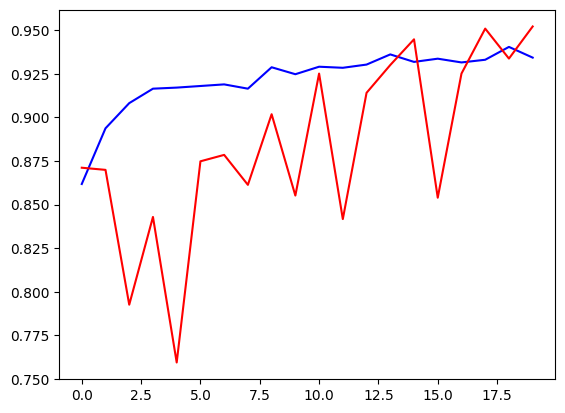

In [31]:
# نمایش عملکرد مدل روی اکیورسی

plt.plot(trained_model.history['accuracy'], color='blue') # داده ترین
plt.plot(trained_model.history['val_accuracy'], color='red') # داده تست

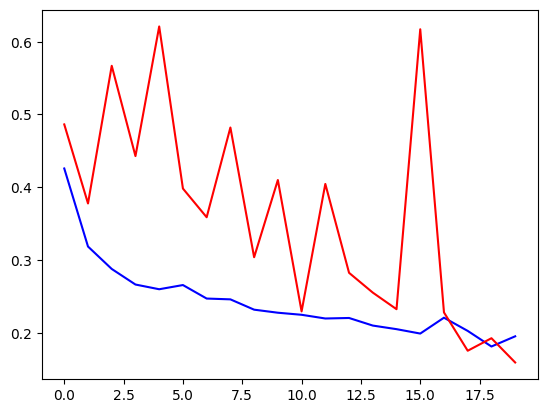

In [32]:
# نمایش عملکرد مدل روی تابع هزینه

plt.plot(trained_model.history['loss'], color='blue') # داده ترین
plt.plot(trained_model.history['val_loss'], color='red') # داده تست

# Testing

In [33]:
# تست کردن مدل روی داده واقعی

image = cv2.imread('person_wearing_mask.jpg')

# کراپ کردن چهره از تصویر

# لود مدل تشخیص چهره
face_detector_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# تشخیص چهره ها
faces = face_detector_model.detectMultiScale(image, minNeighbors=7)

# کراپ کردن چهره
face = image[faces[0][1]:faces[0][3] + faces[0][1], faces[0][0]:faces[0][2] + faces[0][0]]

# ریسایز کردن
face = cv2.resize(face, (216, 216))

# نرمالایز کردن
face = face.astype('float32') / 255.0

# اضافه کردن بعد بچ. برای ورودی مدل لازمه که تعداد مشخص باشه
face = np.expand_dims(face, axis=0)  # شکل از (216, 216, 3) به (1, 216, 216, 3) تغییر میکنه

# پیشبینی توسط مدل
model = keras.models.load_model('face_mask_detector.h5') # برای تنوع از مدل سیو شده استفاده میکنیم
prediction = model.predict(face)
print(prediction)

class_idx = np.argmax(prediction[0]) # ایندکس بیشترین عدد
print(class_idx)

classes = ['Without Mask', 'With Mask', 'Incorrect Mask']  # ترتیب بر اساس وان هات
label = classes[class_idx]

print(f"Predicted class: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
[[3.2126180e-05 9.9613106e-01 3.8367133e-03]]
1
Predicted class: With Mask
